# CE 40719: Deep Learning
## HW6-Q5: REINFORCE (with baseline)

*Full name*: Sayed Hesam Alavian



In this notebook, you are going to implement REINFORCE algorithm on `CartPole-v0` and compare it to the case with a baseline. To know more about this, please refer to [Sutton&Barto, 13.3-13.4](https://www.andrew.cmu.edu/course/10-703/textbook/BartoSutton.pdf). 

In [1]:
%%bash
pip install gym pyvirtualdisplay > /dev/null 2>&1
apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
import gym
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from tqdm.notebook import tqdm
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
import warnings
from collections import namedtuple


warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Auxiliary methods

You can use the following methods to display demos and results of your code.

In [3]:
root = '/content/video'
display = Display(visible=0, size=(200, 150))
display.start()

def show_video(path=root):
    mp4list = glob.glob(f'{path}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 250px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    
def wrap_env(env, path=root):
    return Monitor(env, path, force=True)

def plot_curves(curves, title, smooth=True, w_size=50):
    """
    This method plots series specified in `curves['series']`
    inside the same figure.

    - curves: a dictionary, dict(curves=a list of lists, labels=a list of strings);
    - title: figure's title;
    - smooth: whether to take a moving average over each series;
    - w_size: size of the moving average window;

    Notice: Series must have the same length.
    """
    series, labels = curves['series'], curves['labels']  
    N = len(series[0])
    assert all([len(s) == N for s in series])     
    x = list(range(N))
    for s, label in zip(series, labels):
        window = np.ones(w_size)/w_size
        s_smooth = np.convolve(s, window, mode='same')
        y = s_smooth[w_size:N-w_size] if smooth else s
        plt.plot(x[w_size:N-w_size], y, label=label)
    plt.legend()
    plt.title(title)
    plt.show()

# `CartPole-v0`

You can see specifications of `CartPole-v0` in the following cell.

In [4]:
env_id = 'CartPole-v0'
env = gym.make(env_id)
spec = gym.spec(env_id)

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}\n")

Action Space: Discrete(2)
Observation Space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 195.0



Here you can see a demo of the completely random policy.

In [5]:
env = gym.make('CartPole-v0')
env = wrap_env(env)
state = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
env.close()
show_video()

# Method

You can either use `Net` to create baseline and policy networks, or use any other custom architecture. 

In [6]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, outdim_policy, outdim_baseline):
        super(Net, self).__init__()
        self.shared = nn.Linear(input_dim, hidden_dim)
        self.policy = nn.Linear(hidden_dim, outdim_policy)
        self.baseline = nn.Linear(hidden_dim, outdim_baseline)

    def forward(self, x):
        x = self.shared(x)
        x = F.relu(x)
        p = F.softmax(self.policy(x))
        b = self.baseline(x)
        return p, b

In [7]:
def calculate_discounted_reward(trajectory, t, GAMMA):
    G = 0
    for i, ti in enumerate(trajectory[t:]):
        G += GAMMA**i * ti.reward
    return G

In [8]:
TrajectoryItem = namedtuple("TrajectoryItem", "state action reward log_p value")

class REINFORCECartPole():
    def __init__(self, use_baseline=False, GAMMA=None, lr=None):
        self.env_id = 'CartPole-v0'
        self.env = gym.make(self.env_id)
        self.use_baseline = use_baseline
        self.GAMMA = GAMMA
        ############################ ToDo (1 points) #########################
        # Define your network, optimizer, and criterion.
        ######################################################################
        input_dim = self.env.observation_space.shape[0]
        hidden_dim = 64
        outdim_policy = self.env.action_space.n
        outdim_baseline = 1
        self.net = Net(input_dim, hidden_dim, outdim_policy, outdim_baseline)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def generate_episode(self, video=False, train=True):
        trajectory = []
        ############################ ToDo (2 points) #########################
        # Generate a trajectory from the current policy. This method may be
        # used at training and evaluation time. Also you can record the demo
        # of the trajectory to display later.
        ######################################################################  
        curr_state = self.env.reset()
        done = False

        while not done:
            action, log_p, value= self.select_action(curr_state, train)
            state, reward, done, _ = self.env.step(action)
            ti = TrajectoryItem(state=state, action=action, reward=reward, log_p=log_p, value=value)
            curr_state = state
            trajectory.append(ti)
        if video: 
            show_video()

        return trajectory

    def select_action(self, state, train=True):
        ############################ ToDo (4 points) #########################
        # Select action based on `state`. At training time, you should sample
        # from the policy distribution, but at test time, you need to takes
        # the best possible action.
        ######################################################################
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs, value = self.net(state)
        if train:
            action = np.random.choice(self.env.action_space.n, p=np.squeeze(probs.cpu().detach().numpy()))
        else:
            action = np.argmax(np.squeeze(probs.cpu().detach().numpy()))
        log_p = torch.log(probs.squeeze(0)[action])
        return action, log_p, value

    def train(self, n_episodes, n_eval_episodes=15):
        ############################ ToDo (10 points) ########################
        # Train your networks in the following loop. At the end of each
        # episode, evaluate your networks on `n_eval_episodes` episodes and
        # store average total return of them in `TRs`. You are going to plot
        # these TRs later.
        ######################################################################
        TRs = []
        for i in tqdm(range(n_episodes)):
            trajectory = self.generate_episode()
            discounted = [calculate_discounted_reward(trajectory, t, self.GAMMA) for t in range(len(trajectory))]
            discounted = torch.tensor(discounted)
            grad = []
            if self.use_baseline:
                values = torch.tensor([ti.value for ti in trajectory])
                values_loss = self.criterion(values, discounted)
                deltas = torch.tensor([G - v for G, v in zip(discounted, values)])
                for d, ti in zip(deltas, trajectory):
                    grad.append(- d * ti.log_p)
                self.optimizer.zero_grad()
                grad = torch.stack(grad).sum()
                total_loss = grad + values_loss
                total_loss.backward()
                self.optimizer.step()
                total_return = self.evaluate(n_eval_episodes)
                TRs.append(total_return)
                print(int(total_return), end="\n" if i%10==0 else "  ")
            else:
                for G, ti in zip(discounted, trajectory):
                    grad.append(- ti.log_p * G)
                self.optimizer.zero_grad()
                grad = torch.stack(grad).sum()
                grad.backward()
                self.optimizer.step()
                total_return = self.evaluate(n_eval_episodes)
                TRs.append(total_return)
                print(int(total_return), end="\n" if i%10==0 else "  ")
        return TRs


    def evaluate(self, n_episodes):
        ############################ ToDo (2 points) #########################
        # Evaluate your networks on `n_episodes` episodes and return the 
        # average **undiscounted** total return.
        ######################################################################
        total = 0
        for episode in range(n_episodes):
            trajectory = self.generate_episode(train=False)
            total += sum([ti.reward for ti in trajectory])
        return total/n_episodes

    def show_demo(self):
        ############################ ToDo (1 points) #########################
        # Display demo of one episode based on the current policy.
        ######################################################################
        self.generate_episode(video=True, train=False)

# Results & conclusion

In [11]:
# First you need to choose appropriate input values.
n = 1000
lr = 0.005
GAMMA = 0.9
kwargs = dict(GAMMA=GAMMA, lr=lr)

In [12]:
reinforce = REINFORCECartPole(**kwargs)
returns_reinforce = reinforce.train(n)
reinforce.show_demo()

  0%|          | 0/1000 [00:00<?, ?it/s]

9
9  9  9  9  9  9  9  9  9  9
9  9  9  9  9  8  9  9  12  15
19  21  22  22  23  21  25  25  27  27
27  32  35  40  51  80  60  58  62  83
93  141  95  80  81  89  96  114  99  113
140  123  118  93  92  105  105  121  132  112
103  76  74  81  65  63  86  59  53  61
67  62  64  53  53  52  47  48  48  45
52  46  54  49  55  49  49  43  50  51
49  51  53  55  58  51  54  56  63  60
66  73  77  75  81  77  74  78  73  80
83  84  81  71  89  81  89  90  78  77
80  75  76  83  79  76  80  89  89  103
131  173  200  200  200  200  200  200  200  200
200  200  200  137  128  115  112  110  103  68
62  78  84  96  108  108  118  120  119  118
126  136  146  162  194  199  200  200  200  200
200  200  200  200  200  200  200  200  200  200
200  200  196  185  166  153  139  137  135  132
142  137  140  135  149  142  151  151  137  136
134  133  140  122  124  131  144  164  159  160
190  198  200  200  200  200  200  200  200  200
200  200  200  200  200  200  200  200  200  200
200  199  1

In [13]:
kwargs['use_baseline'] = True
reinforce_b = REINFORCECartPole(**kwargs)
returns_reinforce_b = reinforce_b.train(n)
reinforce_b.show_demo()

  0%|          | 0/1000 [00:00<?, ?it/s]

12
17  14  17  23  22  38  38  16  9  9
9  9  9  9  9  9  9  9  9  9
9  9  9  9  9  9  8  9  9  9
13  24  29  27  21  26  39  39  39  40
44  50  52  70  53  49  51  60  56  60
46  65  56  55  49  39  42  43  43  26
24  23  21  22  19  18  17  17  18  20
19  21  22  22  21  20  20  21  24  23
26  29  35  44  59  76  60  107  125  147
102  65  66  65  60  46  45  49  49  70
57  65  74  105  135  87  51  55  53  41
47  45  46  40  39  35  28  25  24  22
23  22  20  18  19  17  18  17  16  17
16  17  13  15  15  15  15  15  15  15
16  16  16  16  15  16  14  14  13  13
13  13  13  13  14  14  14  15  15  14
15  14  13  14  13  13  12  12  12  13
11  11  10  10  10  10  10  9  10  9
9  9  9  9  9  9  9  9  9  9
9  9  9  9  9  9  9  9  9  9
9  9  9  9  9  9  9  9  9  9
10  10  10  11  10  11  11  12  12  14
15  15  16  19  20  22  25  26  27  28
28  33  36  37  36  38  44  46  46  45
55  57  64  69  122  132  165  122  119  133
112  84  80  87  54  67  72  80  105  58
77  74  69  55  65  70 

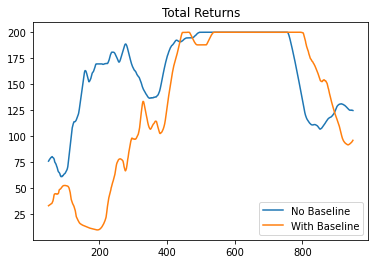

In [14]:
############################ ToDo (1 points) ########################
# Plot total return curves for both methods in the same figure.
#####################################################################
curves = {
    'series':[returns_reinforce, returns_reinforce_b], 
    'labels':['No Baseline', 'With Baseline']
}
plot_curves(curves, title='Total Returns')

**Question: (4 points)**

+ Interpret your results. What is the difference between REINFORCE with baseline and without baseline?

+ What is the difference between REINFORCE with baseline and Actor-Critic methods?

<div dir=rtl>
با توجه به نمودار همگرایی روش REINFORCE همراه با baseline بیش تر است و در نتیجه زودتر همگرا شده است.
 تفاوت این دو روش نحوه محاسبه loss آن ها میباشد.
در روش REINFORCE با baseline مقدار baseline از مقادیر return ها کم شده، سپس در احتمال کنُش ها ضرب شده و در نهایت مجموع آن ها به عنوان loss در نظر گرفته می شود.
ولی  در روش REINFORCE بدون baseline، مقدار return های محاسبه شده به طور مستقیم در احتمال کُنش ها ضرب شده و مجموع آن ها به عنوان loss در نظر گرفته می شود.
baseline در واریانس به روزرسانی و نرخ همگرایی تاثیر گذار است.
همینطور با توجه به نمودار این موضوع هم قابل مشاهده هست که در روش baseline روند آموزش و امتیاز های های میانگین محاسبه شده دارای روندی نرم تر هست و پرش های کمتری دارد.
</div>